### 2018/2019 - Task List 7

[Book](https://raw.githubusercontent.com/jonesgithub/book-1/master/ML%20Machine%20Learning-A%20Probabilistic%20Perspective.pdf)
[Advanced pyro guide](http://pyro.ai/examples/bayesian_regression_ii.html)

0. Fix task list 5 to be a proper linear model (check fixed code in base repository)
1. Reimplement Task List 5 creating guide function manualy
    - create apropriate parameters (mean and std for a and b, sigma - noise)
    - create probabilistic mode using pyro API
    - compute y using sampled a,b
2. Visualize data and learned function (as on Task List 5)
3. Use `AutoMultivariateNormal` guide function
    - all parameters of guide are from normal distribution
    - covariance matrix is not diagonal
4. Visualize results of `AutoMultivariateNormal` vs `AutoDiagonalNormal`


# Required imports

In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import pyro.optim as optim
import pyro.distributions as dist
from torch.distributions import constraints
from tqdm import tqdm_notebook as tqdm
import seaborn as sns
from matplotlib import animation, rc
from IPython.display import HTML
import torch.nn as nn
from functools import partial
import pandas as pd
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO, TracePredictive

In [2]:
pyro.set_rng_seed(1)
#pyro.enable_validation(True)

## Solutions

In [45]:
# enable validation (e.g. validate parameters of distributions)
assert pyro.__version__.startswith('0.3.1')
pyro.enable_validation(True)

# clear the param store in case we're in a REPL
pyro.clear_param_store()

In [46]:
abaloneData = pd.read_csv('abalone_data.csv', sep=',')

abaloneData = abaloneData.sort_values(by=['length'])

x_d = torch.FloatTensor(abaloneData.length.values)
y_d = torch.FloatTensor(abaloneData.diameter.values)

In [47]:
x_d

tensor([0.0750, 0.1100, 0.1300,  ..., 0.7800, 0.8000, 0.8150])

In [48]:
y_d

tensor([0.0550, 0.0900, 0.0950,  ..., 0.6300, 0.6300, 0.6500])

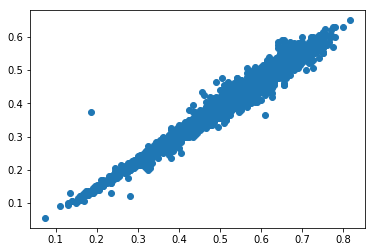

In [49]:
plt.plot(list(x_d), list(y_d), "o")

(array([0.00970566, 0.00970566, 0.0485283 , 0.15529055, 0.19411319,
        0.23293583, 0.30087545, 0.41734361, 0.70851315, 0.67939617,
        0.89292068, 1.37820366, 1.40732064, 1.47526025, 1.58202251,
        2.22259604, 2.54288281, 2.7855243 , 3.11551672, 3.22227898,
        3.86285251, 3.48433179, 3.68815064, 2.69817336, 1.4170263 ,
        1.02879991, 0.69880749, 0.19411319, 0.06793962, 0.01941132]),
 array([0.075     , 0.09966667, 0.12433334, 0.149     , 0.17366667,
        0.19833334, 0.223     , 0.24766667, 0.27233332, 0.297     ,
        0.32166666, 0.34633332, 0.371     , 0.39566666, 0.42033333,
        0.445     , 0.46966666, 0.49433333, 0.519     , 0.54366666,
        0.5683333 , 0.593     , 0.61766666, 0.6423333 , 0.667     ,
        0.69166666, 0.7163333 , 0.741     , 0.76566666, 0.79033333,
        0.815     ], dtype=float32),
 <a list of 30 Patch objects>)

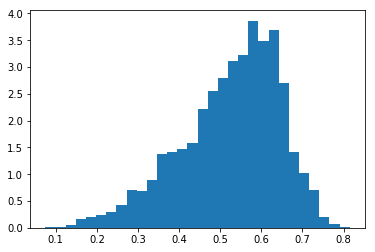

In [50]:
plt.hist(x_d, density=True, bins=30)

(array([0.0120709 , 0.0120709 , 0.13277995, 0.26555999, 0.28970159,
        0.24141817, 0.47076544, 0.82082118, 0.88117634, 0.94153018,
        1.5209345 , 1.68992722, 1.67785632, 1.88305894, 2.63145811,
        2.77630901, 3.44020899, 3.58505451, 3.57298899, 4.35759806,
        4.34552715, 4.50244896, 3.87476171, 2.8970181 , 1.68992722,
        1.02602416, 0.60354544, 0.19313454, 0.07242545, 0.01207091]),
 array([0.055     , 0.07483333, 0.09466667, 0.1145    , 0.13433333,
        0.15416667, 0.174     , 0.19383332, 0.21366666, 0.23349999,
        0.25333333, 0.27316666, 0.29299998, 0.3128333 , 0.33266667,
        0.3525    , 0.37233332, 0.39216664, 0.412     , 0.43183333,
        0.45166665, 0.47149998, 0.4913333 , 0.51116663, 0.53099996,
        0.5508333 , 0.5706667 , 0.5905    , 0.6103333 , 0.63016665,
        0.65      ], dtype=float32),
 <a list of 30 Patch objects>)

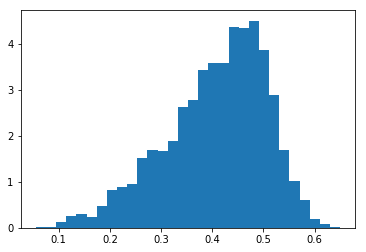

In [51]:
plt.hist(y_d, density=True, bins=30)

In [52]:
# x_d=x[:,None]
# y_d=y[:,None]

In [53]:
class RegressionModel(nn.Module):
    def __init__(self):
        # p = number of features
        super(RegressionModel, self).__init__()
        self.a = nn.Linear(1, 1, bias=False)
        self.b = nn.Parameter(torch.tensor(1.))

    def forward(self, x):
        return self.a(x) + self.b

In [54]:
def create_probabilistic_model():
    regression_model=RegressionModel()
    def probabilistic_model(x_data, y_data):        
        a = pyro.sample("a", dist.Normal(8., 1000.))
        b_a = pyro.sample("bA", dist.Normal(0., 1.))
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = a * x_data + b_a
        
#         with pyro.iarange('data_loop', len(x_data)):
        with pyro.plate("map", len(x_data)):
            pyro.sample("obs", dist.Normal(mean, sigma), obs=y_data)
            return mean
    return probabilistic_model

In [55]:
def guide(x_data, y_data):
    a_loc = pyro.param('w_loc', torch.tensor(0.))
    a_scale = pyro.param('w_scale', torch.tensor(1.),
                        constraint=constraints.positive)
    b_loc = pyro.param('b_loc', torch.tensor(0.))
    b_scale = pyro.param('b_scale', torch.tensor(1.),
                        constraint=constraints.positive)  
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(b_loc, b_scale))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a * x_data + b_a

In [56]:
count = len(x_d)
count

def train():
    pyro.clear_param_store()
    num_iterations = 3000
    model = create_probabilistic_model()
#     guide = AutoDiagonalNormal(model)
    optim = pyro.optim.Adam({"lr": 0.005})
    svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=count)
    t=tqdm(range(num_iterations))
    for j in t:
        loss = svi.step(x_d, y_d)
        t.set_postfix(loss=loss)
    return (model, svi)

In [57]:
def get_marginal(traces, sites):
    empirical_marginal=EmpiricalMarginal(traces, sites)
    return empirical_marginal._get_samples_and_weights()[0].detach().cpu().numpy()

def summary(traces, sites):
    marginal = get_marginal(traces, sites)
    site_stats = {}
    for i in range(marginal.shape[1]):
        site_name = sites[i]
        site_marginal=marginal[:, i]
        marginal_site = pd.DataFrame(site_marginal).transpose()
        describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
        site_stats[site_name] = marginal_site.apply(describe, axis=1) \
            [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

def wrapped_model(x_data, y_data):
    model_result=probabilistic_model(x_data, y_data)
    pyro.sample("prediction", pyro.distributions.Delta(model_result))

In [58]:
x_mean = x_d.mean()
x_mean

tensor(0.5240)

In [59]:
x_std = x_d.std()
x_std

tensor(0.1201)

In [60]:
y_mean = y_d.mean()
y_mean

tensor(0.4079)

In [61]:
y_std = y_d.std()
y_std

tensor(0.0992)

In [62]:
probabilistic_model, svi = train()

In [63]:
for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

w_loc tensor(0.6559, requires_grad=True)
w_scale tensor(0.0426, grad_fn=<AddBackward0>)
b_loc tensor(0.0631, requires_grad=True)
b_scale tensor(0.0304, grad_fn=<AddBackward0>)
sigma_loc tensor(0.1598, grad_fn=<AddBackward0>)


In [64]:
def visualize(posterior):
    trace_pred = TracePredictive(wrapped_model,
                                     posterior,
                                     num_samples=count)

    post_pred = trace_pred.run(x_d, None)
    post_summary = summary(post_pred, sites = ['prediction', 'obs'])
    mu = post_summary["prediction"]
    y = post_summary["obs"]
    predictions = pd.DataFrame({
        "x": x_d,
        "mu_mean": mu["mean"],
        "mu_perc_5": mu["5%"],
        "mu_perc_95": mu["95%"],
        "y_mean": y["mean"],
        "y_perc_5": y["5%"],
        "y_perc_95": y["95%"],
        "true_y": y_d,
    })

    predictions.sort_values('x', inplace=True)
    x_values = torch.FloatTensor(predictions['x'].values.tolist()).squeeze().numpy()

    # plot probabilities
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    plt.plot(x_values, y_d.squeeze().numpy(), "bo")
    plt.plot(x_values, predictions['mu_mean'], 'r');
    plt.fill_between(x_values,
                       predictions["mu_perc_5"],
                       predictions["mu_perc_95"],
                       color='r',
                       alpha=0.5);
    plt.show()

    # plot outcome variables
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    plt.plot(x_values, y_d.squeeze().numpy(), "bo")
    plt.plot(x_values, predictions['y_mean'], 'r');
    plt.fill_between(x_values,
                       predictions["y_perc_5"],
                       predictions["y_perc_95"],
                       color='r',
                       alpha=0.5);
    plt.show()

In [76]:
posterior = svi.run(x_d, y_d)

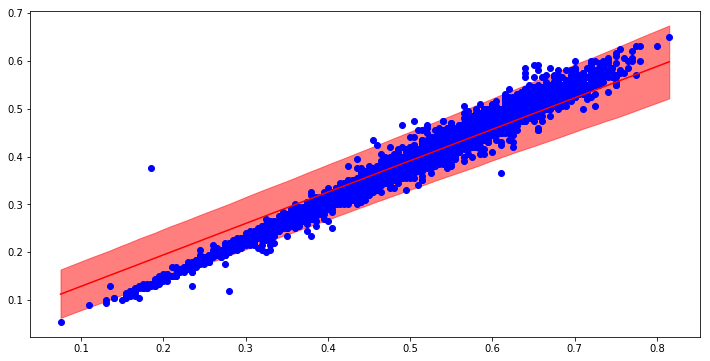

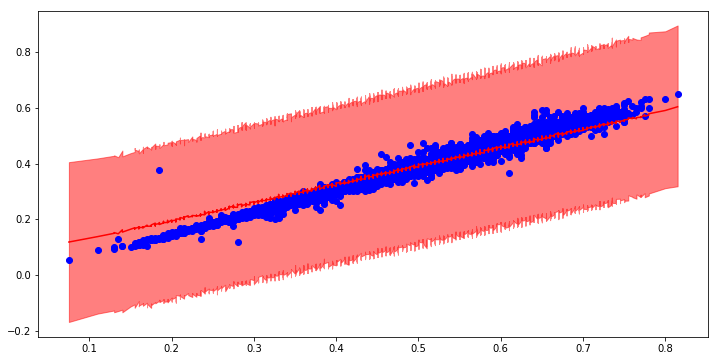

In [77]:
visualize(posterior)

In [78]:
def train_with_guide(guide):
    pyro.clear_param_store()
    num_iterations = 3000
    model = create_probabilistic_model()
    guide = guide(model)
    optim = pyro.optim.Adam({"lr": 0.005})
    svi = pyro.infer.SVI(model, guide, optim, loss=pyro.infer.Trace_ELBO(), num_samples=count)
    t=tqdm(range(num_iterations))
    for j in t:
        loss = svi.step(x_d, y_d)
        t.set_postfix(loss=loss)
    return (model, svi)

auto_loc tensor([ 0.6285,  0.0905, -4.7670], requires_grad=True)
auto_scale_tril tensor([[ 0.3406,  0.0000,  0.0000],
        [-0.1823,  0.0395,  0.0000],
        [-0.1158,  0.0348,  0.3419]], grad_fn=<ViewBackward>)


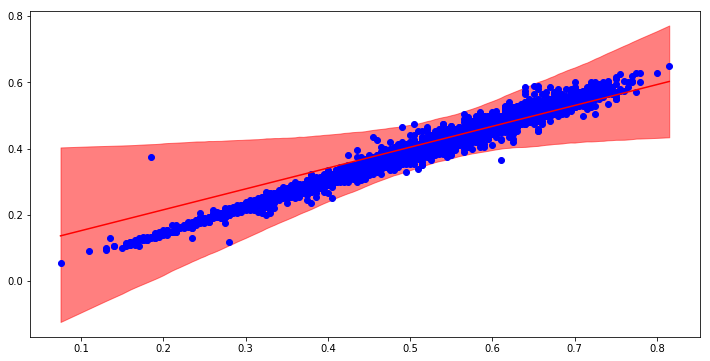

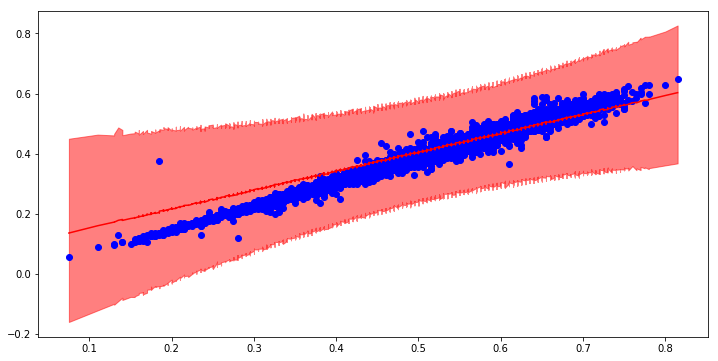

In [79]:
probabilistic_model_multi_normal, svi_multi_normal = train_with_guide(AutoMultivariateNormal)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))
    
multi_normal = svi_multi_normal.run(x_d, y_d)
visualize(multi_normal)

auto_loc tensor([ 0.8137, -0.0220, -6.2525], requires_grad=True)
auto_scale tensor([0.0080, 0.0055, 0.1451], grad_fn=<AddBackward0>)


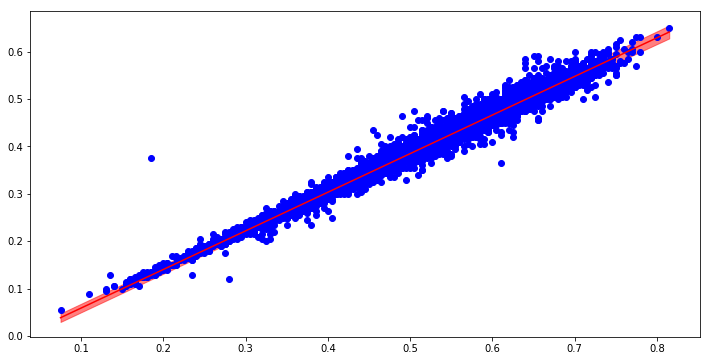

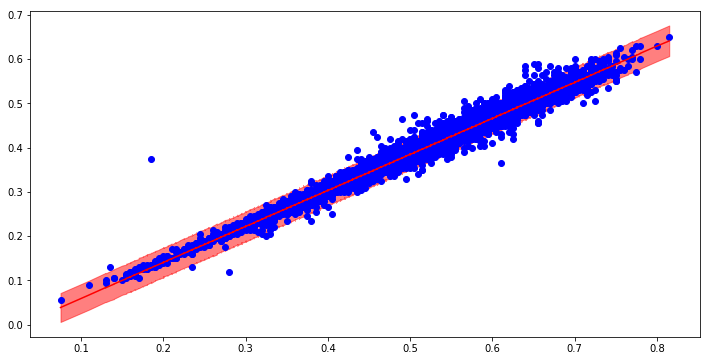

In [80]:
probabilistic_model_normal, svi_normal = train_with_guide(AutoDiagonalNormal)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

posterior_normal = svi_normal.run(x_d, y_d)
visualize(posterior_normal)

In [81]:
import numpy as np
import statistics as stats
from scipy import stats

In [82]:
stats.pearsonr(x_d, y_d)

(0.98681164, 0.0)

In [83]:
np.corrcoef(x_d,y_d)

array([[1.        , 0.98681158],
       [0.98681158, 1.        ]])

In [61]:
# def model(length, diameter, log_gdp):
#     a = pyro.sample("a", dist.Normal(8., 1000.))
#     b_a = pyro.sample("bA", dist.Normal(0., 1.))
#     b_r = pyro.sample("bR", dist.Normal(0., 1.))
#     b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
#     sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
#     mean = a + b_a * length + b_r * diameter + b_ar * length * diameter
#     with pyro.iarange("data", len(diameter)):
#         pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

# def guide(length, diameter, log_gdp):
#     a_loc = pyro.param('a_loc', torch.tensor(0.))
#     a_scale = pyro.param('a_scale', torch.tensor(1.), constraint=constraints.positive)
#     sigma_loc = pyro.param('sigma_loc', torch.tensor(1.), constraint=constraints.positive)
#     weights_loc = pyro.param('weights_loc', torch.randn(3))
#     weights_scale = pyro.param('weights_scale', torch.ones(3), constraint=constraints.positive)
#     a = pyro.sample("a", dist.Normal(a_loc, a_scale))
#     b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
#     b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
#     b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
#     sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
#     mean = a + b_a * length + b_r * diameter + b_ar * length * diameter

In [36]:
# # Utility function
# def summary(traces, sites):
#     marginal = EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()
#     site_stats = {}
#     for i in range(marginal.shape[1]):
#         site_name = sites[i]
#         marginal_site = pd.DataFrame(marginal[:, i]).transpose()
#         describe = partial(pd.Series.describe, percentiles=[.05, 0.25, 0.5, 0.75, 0.95])
#         site_stats[site_name] = marginal_site.apply(describe, axis=1) \
#             [["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
#     return site_stats

# # Prepare training data
# df = rugged_data[["cont_africa", "rugged", "rgdppc_2000"]]
# df = df[np.isfinite(df.rgdppc_2000)]
# df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
# train = torch.tensor(df.values, dtype=torch.float)

NameError: name 'rugged_data' is not defined